## Shallow-net Audio Style Transfer
This notebook applies shallow net to perform audio style transfer.

### Import necessary dependencies

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import librosa
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import Audio
import soundfile as sf

### Utils

In [3]:
fs = 16000
N_FFT=2048
N_FILTERS = 2048

# x_content, _ = librosa.load('eminem.mp3')
# x_style, _ = librosa.load('gettysburg.mp3')

# mel_content = librosa.feature.melspectrogram(y=x_content, sr=fs, n_mels=512, fmax=8000)
# mel_style = librosa.feature.melspectrogram(y=x_style, sr=fs, n_mels=512, fmax=8000)

def read_audio_spectum(filename):
    x, fs = librosa.load(filename)
    S = librosa.stft(x,n_fft= N_FFT)
    p = np.angle(S)

    S = np.log1p(np.abs(S[:,:430]))
    return S, fs

#Can use nn.Sequential instead
class Shallow_net(nn.Sequential):
  def __init__(self, in_channel, out_channel):
    super(Shallow_net, self).__init__(nn.Conv2d(in_channel, out_channel, (1, 11)), nn.ReLU())

  # def forward(self, x):
  #   out = self.conv(x)
  #   out = self.relu(out)
  #   return out

def init_weights(m):
  if isinstance(m, nn.Conv2d):
    std = np.sqrt(2) * np.sqrt(2.0 / ((m.weight.shape[0]+m.weight.shape[1]) * 11))
    m.weight.data.normal_(std = std)

class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

def gram_matrix(input, n_samples):
    a, b, c, d = input.size()
    features = input.reshape(a * b, c * d)
    G = torch.mm(features, features.t())
    return G.div(n_samples)

class StyleLoss(nn.Module):
    def __init__(self, target_feature, n_samples):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature, n_samples).detach()
        self.n_samples = n_samples
    def forward(self, input):
        G = gram_matrix(input, self.n_samples)
        self.loss = F.mse_loss(G, self.target)
        return input

#Adjust layers
def adjust_net(net, nb_filters):
  index = 2
  net.add_module('conv_{}'.format(index), nn.Conv2d(N_FILTERS, nb_filters[0], (1,11)))
  net.add_module('relu_{}'.format(torch.index_add), nn.ReLU())
  for i in range(len(nb_filters)-1):
    net.add_module('conv_{}'.format(index), nn.Conv2d(nb_filters[i+1], nb_filters[i+1], (1,11)))
    net.add_module('relu_{}'.format(index), nn.ReLU())
    index += 1
  return net

def get_input_optimizer(input_audio):
    optimizer = optim.LBFGS([input_audio])
    return optimizer

### Model definition

In [4]:
content_layers_default = ['relu_1']
style_layers_default = ['relu_1', 'relu_2']

def get_style_model_and_losses(a_style, a_content,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):                            
    net = Shallow_net(1025, N_FILTERS)
    nb_filters = [2048]
    net = adjust_net(net, nb_filters)
    net.apply(init_weights)
    
    N_SAMPLES = a_content.shape[1]
    N_CHANNELS = a_content.shape[0]

    a_content = torch.tensor(a_content)
    a_content = torch.reshape(a_content, (1, N_CHANNELS, 1, N_SAMPLES))
    a_style = torch.tensor(a_style)
    a_style = torch.reshape(a_style, (1, N_CHANNELS, 1, N_SAMPLES))

    a_input = a_content.clone().contiguous()

    style_losses = []
    content_losses = []
    i = 0

    transfer_net = nn.Sequential()

    for layer in net.children():
      if isinstance(layer, nn.Conv2d):
        i += 1
        name = "conv_{}".format(i)
      elif isinstance(layer, nn.ReLU):
        name = 'relu_{}'.format(i)

      transfer_net.add_module(name, layer)

      if name in content_layers:
        target_content = transfer_net(a_content).detach()
        content_loss = ContentLoss(target_content)
        transfer_net.add_module("Content_loss_conv_{}".format(i), content_loss)
        content_losses.append(content_loss)
      if name in style_layers:
        target_style = transfer_net(a_style).detach()
        style_loss = StyleLoss(target_style, N_SAMPLES)
        transfer_net.add_module("Style_loss_conv_{}".format(i), style_loss)
        style_losses.append(style_loss)

    transfer_net.eval()
    transfer_net.requires_grad_(False)
    
    return transfer_net, style_losses, content_losses, a_input
    
def run_audio_style_tranfer(a_content, a_style, num_steps=300,
                       style_weight=1000000, content_weight=1):
    print('Building the style transfer model..')

    model, style_losses, content_losses, a_input = get_style_model_and_losses(a_style, a_content)

    a_input.requires_grad_(True)
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(a_input)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

      def closure():
        # with torch.no_grad():
        #     input_audio.clamp_(0, 1)

        optimizer.zero_grad()
        model(a_input)
        style_score = 0
        content_score = 0

        for sl in style_losses:
            style_score += sl.loss
        for cl in content_losses:
            content_score += cl.loss

        style_score *= style_weight
        content_score *= content_weight

        loss = style_score + content_score
        loss.backward()

        run[0] += 1
        if run[0] % 10 == 0:
            print("run {}:".format(run))
            print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                style_score.item(), content_score.item()))
            print()

        return style_score + content_score

      optimizer.step(closure)

    # with torch.no_grad():
    #     input_img.clamp_(0, 1)

    return a_input

### Running and visualizing

In [5]:
script_directory = os.getcwd()
data_folder = os.path.join(script_directory, '..', 'data')

#### Piano to drum (same song)

In [25]:
content_path= os.path.join(data_folder,  "yursong.wav")
style_path = os.path.join(data_folder,  "yursong_drum.wav")
a_content, fs = read_audio_spectum(content_path)
a_style, fs = read_audio_spectum(style_path)

N_SAMPLES = a_content.shape[1]
N_CHANNELS = a_content.shape[0]
a_style = a_style[:N_CHANNELS, a_style.shape[1]-N_SAMPLES:]

a_input = run_audio_style_tranfer(a_content, a_style, num_steps=100, style_weight=1000000, content_weight=1)

a_output = a_input.reshape((N_CHANNELS, N_SAMPLES))
a_output = a_output.detach().numpy()

Building the style transfer model..
Optimizing..
run [10]:
Style Loss : 758.719727 Content Loss: 0.008159

run [20]:
Style Loss : 54.381977 Content Loss: 0.038224

run [30]:
Style Loss : 13.146178 Content Loss: 0.045411

run [40]:
Style Loss : 6.061836 Content Loss: 0.045201

run [50]:
Style Loss : 3.258602 Content Loss: 0.045561

run [60]:
Style Loss : 2.031196 Content Loss: 0.045995

run [70]:
Style Loss : 1.371126 Content Loss: 0.046043

run [80]:
Style Loss : 1.002743 Content Loss: 0.045967

run [90]:
Style Loss : 0.765870 Content Loss: 0.045822

run [100]:
Style Loss : 0.608967 Content Loss: 0.045741

run [110]:
Style Loss : 0.497289 Content Loss: 0.045612

run [120]:
Style Loss : 0.418970 Content Loss: 0.045486



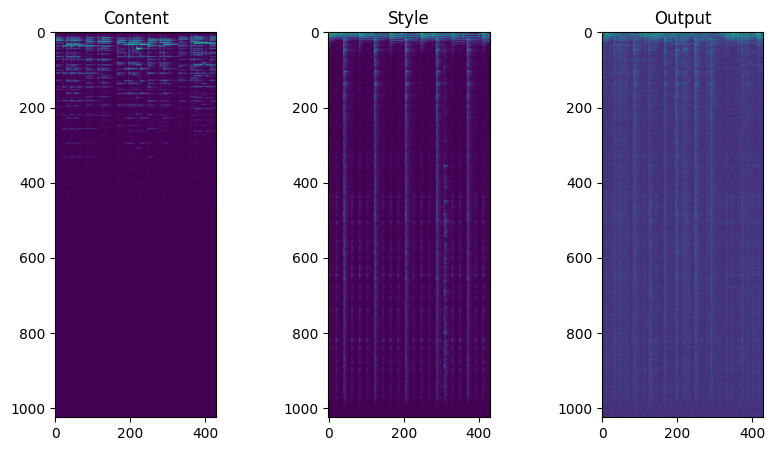

In [21]:
plt.figure(figsize=(10, 5))
plt.subplot(1,3,1)
plt.imshow(a_content)
plt.title("Content")
plt.subplot(1,3,2)
plt.imshow(a_style)
plt.title("Style")
plt.subplot(1,3,3)
plt.imshow(a_output)
plt.title("Output")
plt.show()

In [ ]:
a = np.zeros_like(a_output)
a[:N_CHANNELS,:] = np.exp(a_output) - 1
p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
for i in range(500):
    S = a * np.exp(1j*p)
    x = librosa.istft(S)
    p = np.angle(librosa.stft(x, n_fft=N_FFT))

OUTPUT_FILENAME = 'out_shallow.wav'
sf.write(OUTPUT_FILENAME, x, fs, 'PCM_24')
print("Content")
display(Audio(content_path))
print("Style")
display(Audio(style_path))
print("Output")
display(Audio("out_shallow.wav"))

#### Piano to String (same song)

In [6]:
content_path= os.path.join(data_folder,  "yursong.wav")
style_path = os.path.join(data_folder,  "yursong_string.wav")
a_content, fs = read_audio_spectum(content_path)
a_style, fs = read_audio_spectum(style_path)

N_SAMPLES = a_content.shape[1]
N_CHANNELS = a_content.shape[0]
a_style = a_style[:N_CHANNELS, a_style.shape[1]-N_SAMPLES:]

a_input = run_audio_style_tranfer(a_content, a_style, num_steps=100, style_weight=10000000, content_weight=1)

a_output = a_input.reshape((N_CHANNELS, N_SAMPLES))
a_output = a_output.detach().numpy()

Building the style transfer model..
Optimizing..
run [10]:
Style Loss : 133.982971 Content Loss: 0.015322

run [20]:
Style Loss : 17.116480 Content Loss: 0.020196

run [30]:
Style Loss : 6.462771 Content Loss: 0.020874

run [40]:
Style Loss : 3.894486 Content Loss: 0.021204

run [50]:
Style Loss : 2.758816 Content Loss: 0.021417

run [60]:
Style Loss : 2.127337 Content Loss: 0.021459

run [70]:
Style Loss : 1.706053 Content Loss: 0.021572

run [80]:
Style Loss : 1.432091 Content Loss: 0.021581

run [90]:
Style Loss : 1.231442 Content Loss: 0.021602

run [100]:
Style Loss : 1.072032 Content Loss: 0.021654

run [110]:
Style Loss : 0.950900 Content Loss: 0.021694

run [120]:
Style Loss : 0.861229 Content Loss: 0.021713



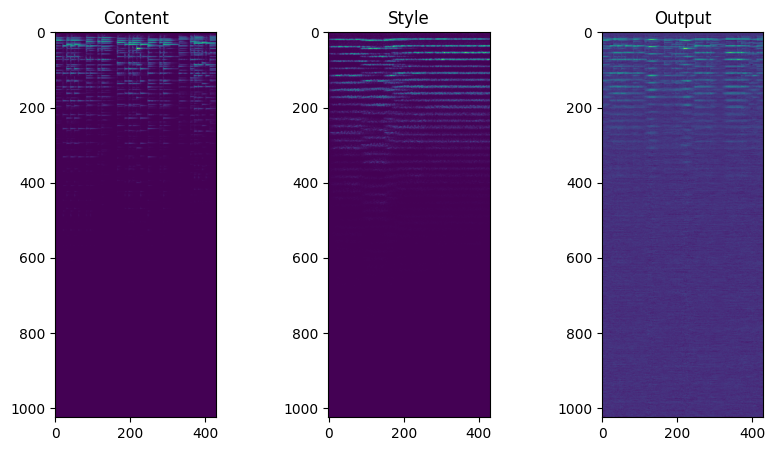

In [7]:
plt.figure(figsize=(10, 5))
plt.subplot(1,3,1)
plt.imshow(a_content)
plt.title("Content")
plt.subplot(1,3,2)
plt.imshow(a_style)
plt.title("Style")
plt.subplot(1,3,3)
plt.imshow(a_output)
plt.title("Output")
plt.show()

In [ ]:
a = np.zeros_like(a_output)
a[:N_CHANNELS,:] = np.exp(a_output) - 1
p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
for i in range(500):
    S = a * np.exp(1j*p)
    x = librosa.istft(S)
    p = np.angle(librosa.stft(x, n_fft=N_FFT))

OUTPUT_FILENAME = 'out_shallow.wav'
sf.write(OUTPUT_FILENAME, x, fs, 'PCM_24')
print("Content")
display(Audio(content_path))
print("Style")
display(Audio(style_path))
print("Output")
display(Audio("out_shallow.wav"))

#### Harp to Drum (same song)

In [9]:
content_path= os.path.join(data_folder,  "yursong_harp.wav")
style_path = os.path.join(data_folder,  "yursong_drum.wav")
a_content, fs = read_audio_spectum(content_path)
a_style, fs = read_audio_spectum(style_path)

N_SAMPLES = a_content.shape[1]
N_CHANNELS = a_content.shape[0]
a_style = a_style[:N_CHANNELS, a_style.shape[1]-N_SAMPLES:]

a_input = run_audio_style_tranfer(a_content, a_style, num_steps=100, style_weight=1000000, content_weight=1)

a_output = a_input.reshape((N_CHANNELS, N_SAMPLES))
a_output = a_output.detach().numpy()

Building the style transfer model..
Optimizing..
run [10]:
Style Loss : 571.736389 Content Loss: 0.008225

run [20]:
Style Loss : 48.853283 Content Loss: 0.032591

run [30]:
Style Loss : 11.996506 Content Loss: 0.039815

run [40]:
Style Loss : 5.261837 Content Loss: 0.039946

run [50]:
Style Loss : 2.823254 Content Loss: 0.040514

run [60]:
Style Loss : 1.782744 Content Loss: 0.040823

run [70]:
Style Loss : 1.210340 Content Loss: 0.040900

run [80]:
Style Loss : 0.882545 Content Loss: 0.040806

run [90]:
Style Loss : 0.693805 Content Loss: 0.040755

run [100]:
Style Loss : 0.556336 Content Loss: 0.040661

run [110]:
Style Loss : 0.464663 Content Loss: 0.040574

run [120]:
Style Loss : 0.395112 Content Loss: 0.040487



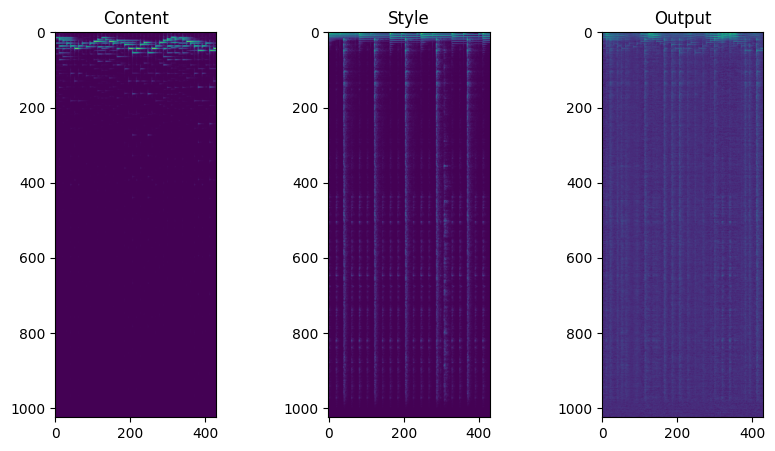

In [10]:
plt.figure(figsize=(10, 5))
plt.subplot(1,3,1)
plt.imshow(a_content)
plt.title("Content")
plt.subplot(1,3,2)
plt.imshow(a_style)
plt.title("Style")
plt.subplot(1,3,3)
plt.imshow(a_output)
plt.title("Output")
plt.show()

In [ ]:
a = np.zeros_like(a_output)
a[:N_CHANNELS,:] = np.exp(a_output) - 1
p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
for i in range(500):
    S = a * np.exp(1j*p)
    x = librosa.istft(S)
    p = np.angle(librosa.stft(x, n_fft=N_FFT))

OUTPUT_FILENAME = 'out_shallow.wav'
sf.write(OUTPUT_FILENAME, x, fs, 'PCM_24')
print("Content")
display(Audio(content_path))
print("Style")
display(Audio(style_path))
print("Output")
display(Audio("out_shallow.wav"))

#### Drum to Piano (same song)

In [11]:
content_path= os.path.join(data_folder,  "yursong_drum.wav")
style_path = os.path.join(data_folder,  "yursong.wav")
a_content, fs = read_audio_spectum(content_path)
a_style, fs = read_audio_spectum(style_path)

N_SAMPLES = a_content.shape[1]
N_CHANNELS = a_content.shape[0]
a_style = a_style[:N_CHANNELS, a_style.shape[1]-N_SAMPLES:]

a_input = run_audio_style_tranfer(a_content, a_style, num_steps=100, style_weight=10000000, content_weight=1)

a_output = a_input.reshape((N_CHANNELS, N_SAMPLES))
a_output = a_output.detach().numpy()

Building the style transfer model..
Optimizing..
run [10]:
Style Loss : 415.416748 Content Loss: 0.024818

run [20]:
Style Loss : 67.192848 Content Loss: 0.036339

run [30]:
Style Loss : 29.331293 Content Loss: 0.038246

run [40]:
Style Loss : 14.549396 Content Loss: 0.039257

run [50]:
Style Loss : 9.043746 Content Loss: 0.040063

run [60]:
Style Loss : 6.262652 Content Loss: 0.040248

run [70]:
Style Loss : 4.644616 Content Loss: 0.040478

run [80]:
Style Loss : 3.578909 Content Loss: 0.040646

run [90]:
Style Loss : 2.913087 Content Loss: 0.040703

run [100]:
Style Loss : 2.446847 Content Loss: 0.040736

run [110]:
Style Loss : 2.102765 Content Loss: 0.040745

run [120]:
Style Loss : 1.849802 Content Loss: 0.040773



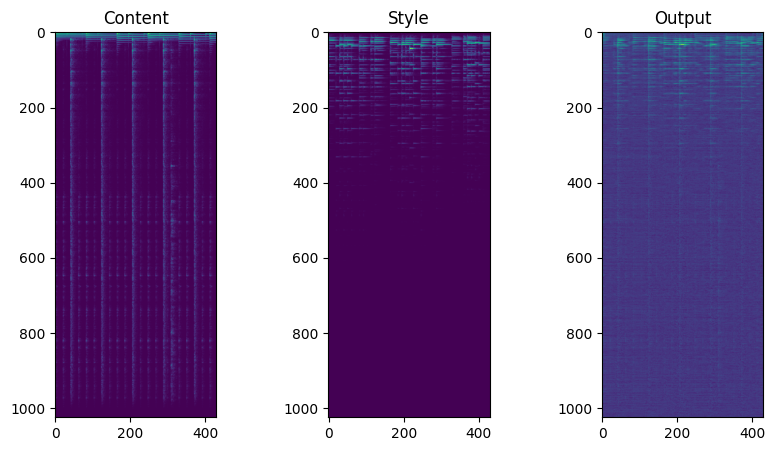

In [12]:
plt.figure(figsize=(10, 5))
plt.subplot(1,3,1)
plt.imshow(a_content)
plt.title("Content")
plt.subplot(1,3,2)
plt.imshow(a_style)
plt.title("Style")
plt.subplot(1,3,3)
plt.imshow(a_output)
plt.title("Output")
plt.show()

In [ ]:
a = np.zeros_like(a_output)
a[:N_CHANNELS,:] = np.exp(a_output) - 1
p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
for i in range(500):
    S = a * np.exp(1j*p)
    x = librosa.istft(S)
    p = np.angle(librosa.stft(x, n_fft=N_FFT))

OUTPUT_FILENAME = 'out_shallow.wav'
sf.write(OUTPUT_FILENAME, x, fs, 'PCM_24')
print("Content")
display(Audio(content_path))
print("Style")
display(Audio(style_path))
print("Output")
display(Audio("out_shallow.wav"))

#### Piano to Drum (different song)

In [13]:
content_path= os.path.join(data_folder,  "yursong.wav")
style_path = os.path.join(data_folder,  "atIknew.wav")
a_content, fs = read_audio_spectum(content_path)
a_style, fs = read_audio_spectum(style_path)

N_SAMPLES = a_content.shape[1]
N_CHANNELS = a_content.shape[0]
a_style = a_style[:N_CHANNELS, a_style.shape[1]-N_SAMPLES:]

a_input = run_audio_style_tranfer(a_content, a_style, num_steps=100, style_weight=10000000, content_weight=1)

a_output = a_input.reshape((N_CHANNELS, N_SAMPLES))
a_output = a_output.detach().numpy()

Building the style transfer model..
Optimizing..
run [10]:
Style Loss : 2906925568.000000 Content Loss: 16.571482

run [20]:
Style Loss : 13463.551758 Content Loss: 0.015288

run [30]:
Style Loss : 816.375183 Content Loss: 0.059529

run [40]:
Style Loss : 230.615463 Content Loss: 0.063989

run [50]:
Style Loss : 92.133713 Content Loss: 0.064564

run [60]:
Style Loss : 50.062874 Content Loss: 0.064516

run [70]:
Style Loss : 30.287952 Content Loss: 0.064386

run [80]:
Style Loss : 21.259451 Content Loss: 0.063948

run [90]:
Style Loss : 15.718401 Content Loss: 0.063585

run [100]:
Style Loss : 12.311312 Content Loss: 0.063330

run [110]:
Style Loss : 9.683521 Content Loss: 0.063082

run [120]:
Style Loss : 7.985657 Content Loss: 0.062915



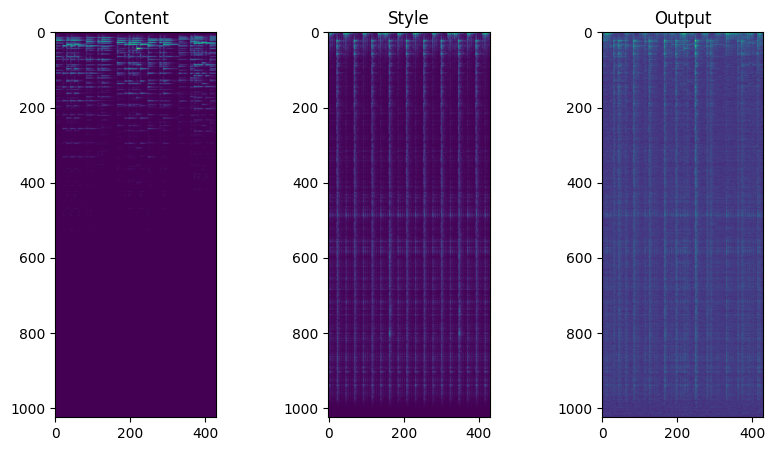

In [14]:
plt.figure(figsize=(10, 5))
plt.subplot(1,3,1)
plt.imshow(a_content)
plt.title("Content")
plt.subplot(1,3,2)
plt.imshow(a_style)
plt.title("Style")
plt.subplot(1,3,3)
plt.imshow(a_output)
plt.title("Output")
plt.show()

In [ ]:
a = np.zeros_like(a_output)
a[:N_CHANNELS,:] = np.exp(a_output) - 1
p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
for i in range(500):
    S = a * np.exp(1j*p)
    x = librosa.istft(S)
    p = np.angle(librosa.stft(x, n_fft=N_FFT))

OUTPUT_FILENAME = 'out_shallow.wav'
sf.write(OUTPUT_FILENAME, x, fs, 'PCM_24')
print("Content")
display(Audio(content_path))
print("Style")
display(Audio(style_path))
print("Output")
display(Audio("out_shallow.wav"))

#### Drum to Piano (different song)

In [15]:
content_path= os.path.join(data_folder,  "atIknew.wav")
style_path = os.path.join(data_folder,  "yursong.wav")
a_content, fs = read_audio_spectum(content_path)
a_style, fs = read_audio_spectum(style_path)

N_SAMPLES = a_content.shape[1]
N_CHANNELS = a_content.shape[0]
a_style = a_style[:N_CHANNELS, a_style.shape[1]-N_SAMPLES:]

a_input = run_audio_style_tranfer(a_content, a_style, num_steps=100, style_weight=10000000, content_weight=1)

a_output = a_input.reshape((N_CHANNELS, N_SAMPLES))
a_output = a_output.detach().numpy()

Building the style transfer model..
Optimizing..
run [10]:
Style Loss : 229.091690 Content Loss: 0.052587

run [20]:
Style Loss : 76.363174 Content Loss: 0.059950

run [30]:
Style Loss : 31.077116 Content Loss: 0.061327

run [40]:
Style Loss : 16.146896 Content Loss: 0.063442

run [50]:
Style Loss : 10.158120 Content Loss: 0.063937

run [60]:
Style Loss : 7.084295 Content Loss: 0.064267

run [70]:
Style Loss : 5.276266 Content Loss: 0.064454

run [80]:
Style Loss : 4.142661 Content Loss: 0.064506

run [90]:
Style Loss : 3.379064 Content Loss: 0.064545

run [100]:
Style Loss : 2.846733 Content Loss: 0.064551

run [110]:
Style Loss : 2.459427 Content Loss: 0.064516

run [120]:
Style Loss : 2.182703 Content Loss: 0.064536



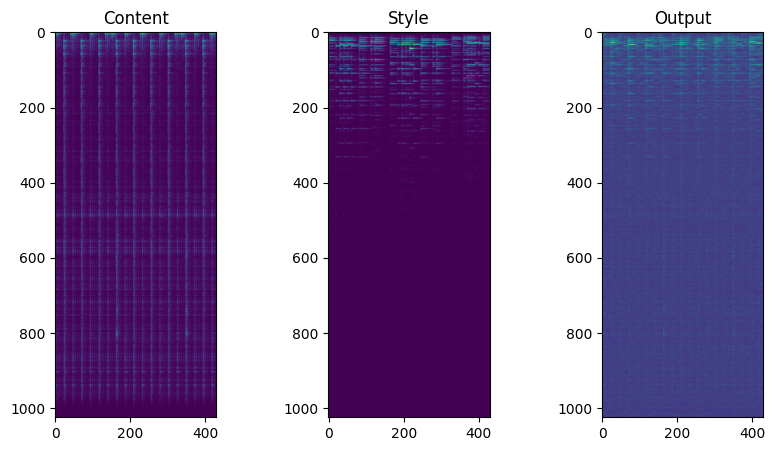

In [16]:
plt.figure(figsize=(10, 5))
plt.subplot(1,3,1)
plt.imshow(a_content)
plt.title("Content")
plt.subplot(1,3,2)
plt.imshow(a_style)
plt.title("Style")
plt.subplot(1,3,3)
plt.imshow(a_output)
plt.title("Output")
plt.show()

In [ ]:
a = np.zeros_like(a_output)
a[:N_CHANNELS,:] = np.exp(a_output) - 1
p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
for i in range(500):
    S = a * np.exp(1j*p)
    x = librosa.istft(S)
    p = np.angle(librosa.stft(x, n_fft=N_FFT))

OUTPUT_FILENAME = 'out_shallow.wav'
sf.write(OUTPUT_FILENAME, x, fs, 'PCM_24')
print("Content")
display(Audio(content_path))
print("Style")
display(Audio(style_path))
print("Output")
display(Audio("out_shallow.wav"))